In [1]:
import ms_import as ms
from UniDec import unidec
from UniDec.unidec_modules import unidectools as ud
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
# upload .d file and export mean spectrum within time window to text file
mean_spectrum = ms.upload_bruker(analysis_dir = "example_analysis.d", filename = "mean_data4.txt", 
                                 mean_window = True, upload = True)

Specified BAF has 159 spectra with line and profile data.


In [3]:
# upload text file to UniDec and deconvolve 

eng = unidec.UniDec()
eng.open_file("mean_data4.txt")

# -- Data processing
eng.config.subtype = 2 # background subtraction - subtract curved
eng.config.subbuff = 100 # background subtraction amount(subtract curved) 0 = 0ff, 100 = good amount when on
eng.config.datanorm = 0 # turn off data normalisation

# -- Deconvolution
eng.config.numit = 100 # number of iterations

# mass range (default = 5000.0 to 500000.0 Da)
eng.config.massub = 13200 # upper 
eng.config.masslb = 11600 # lower

eng.config.massbins = 0.1 # sample mass every 0.1 Da

# generate FWHM 
eng.get_auto_peak_width()

# charge range
eng.config.startz = 1
eng.config.endz = 20

# smoothing 
eng.config.zzsig = 1 # charge smooth width (smooth charge state distributions)
eng.config.psig = 1 # smooth nearby points (point smooth width, some = 1)
eng.config.beta = 0 # suppress artifacts (beta, some = 50)

eng.config.psfun = 0 # Peak shape function (gaussian, lorentzian, split G/L)

# Peak Selection and plotting
eng.config.peaknorm = 0 # Normalise peaks (0 = off)
eng.config.peakwindow = 10 # integration window / Da



UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\MS-Analysis\UniDec\unidec_bin\UniDec.exe
Opening File:  mean_data4.txt
Loading Time: 5.4s
Automatic Peak Width: 0.0311


In [4]:
eng.process_data()
eng.run_unidec()

Linear False
Data Prep Time: 3.1s
UniDec run 4.3s
File Name:  mean_data4.txt R Squared:  0.9765614563451843


0

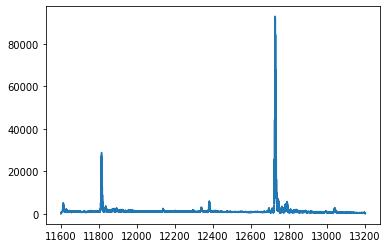

In [5]:
plt.plot(eng.data.massdat[:, 0], eng.data.massdat[:, 1])
plt.show()

In [6]:
# find peaks
# ud.peakdetect(eng.data.massdat, eng.config)

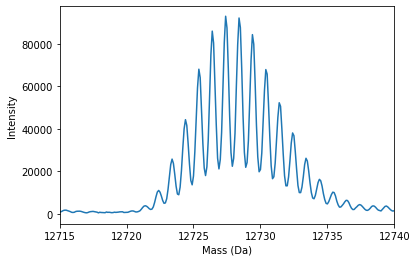

In [7]:
# zoom in on peaks 
mass_dist_data = np.loadtxt("mean_data4_unidecfiles/mean_data4_mass.txt")

plt.plot(mass_dist_data[:, 0], mass_dist_data[:, 1])
plt.xlim(12715, 12740)
plt.xlabel('Mass (Da)')
plt.ylabel('Intensity')
plt.show()

In [8]:
# pick peaks and extract peak info 
eng.pick_peaks()
eng.export_params(0)

Exported data to mean_data4_unidecfiles\mean_data4_chargedata.dat
Mass MassStdGuess AvgCharge StdDevCharge Height Area MassCentroid MassFWHM MassErrorBetweenZ
[[ 11813.20  0.29  9.17  1.64  28901.04  136651.26  11813.16  0.70  0.29]
 [ 12727.40  0.29  9.21  1.37  92969.46  444470.87  12727.41  0.60  0.32]]
Peak Parameters (Saved To mean_data4_unidecfiles\mean_data4_peakparam.dat )


In [9]:
# export peak params into separate lists
peak_areas = [] 
peak_intensities = []
masses = []
for i in range(0, len(eng.peakparams)):
    
    peak_areas.append(eng.peakparams[i][5])
    peak_intensities.append(eng.peakparams[i][4])
    masses.append(eng.peakparams[i][0])

    print("Peak {} Area: {}".format(i+1, eng.peakparams[i][5]))
    print("Peak {} Intensity: {}".format(i+1, eng.peakparams[i][4]))

Peak 1 Area: 136651.26251796255
Peak 1 Intensity: 28901.041016
Peak 2 Area: 444470.86804388405
Peak 2 Intensity: 92969.460938


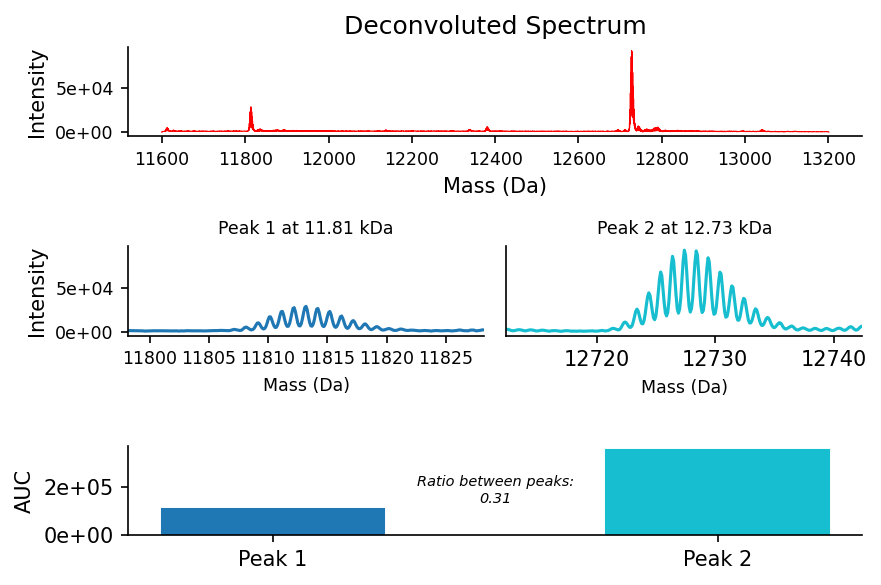

In [15]:
# peak windows
peak_windows = [[i-15, i+15] for i in masses]
peak_nums = ["Peak {}".format(i+1) for i in range(len(peak_areas))]

fig = plt.figure(tight_layout = True, dpi = 150)

gs = gridspec.GridSpec(3, (len(peak_nums)))

def get_colors(number, cmap = 'tab10'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, number))
    return colors

# full spectrum
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(eng.data.massdat[:, 0], eng.data.massdat[:, 1], c = 'red', linewidth = 0.5)
ax1.set_title("Deconvoluted Spectrum")
ax1.set_xlabel("Mass (Da)")
ax1.set_ylabel("Intensity")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax1.tick_params(labelsize = 'small')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


for i in range(len(peak_nums)):
    
    ax2 = fig.add_subplot(gs[1, i])
    ax2.plot(eng.data.massdat[:, 0], eng.data.massdat[:, 1], c = get_colors(len(peak_nums))[i])
    ax2.set_xlim(peak_windows[i][0], peak_windows[i][1])
    ax2.set_title("{} at {:.2f} kDa".format(peak_nums[i], masses[i]/1000), fontsize = 'small')
    ax2.set_xlabel("Mass (Da)", fontsize = 'small')
    
    if i == 0:
        ax2.set_ylabel("Intensity")
        ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        ax2.tick_params(labelsize = 'small')
    else:
        ax2.tick_params(left = False)
        ax2.set(yticklabels = [])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    
ax3 = fig.add_subplot(gs[2, :])
barchart = ax3.bar(peak_nums, peak_areas, width = 0.5)

for i in range(len(peak_nums)):
    
    barchart[i].set_color(get_colors(len(peak_nums))[i])
    
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax3.set_ylabel("AUC")
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

if len(peak_nums) == 2:
    ax3.annotate("Ratio between peaks:\n{:.2f}".format(peak_areas[0]/peak_areas[1]), 
                 (0.5, 0.5), xycoords='axes fraction', va='center', ha='center', 
                 fontsize = 'x-small', fontstyle = 'oblique')

plt.show()